# 指标的计算及在量化策略中的应用-Pybroker

## 老师整理的资料

pybroker框架的模块中文说明

https://www.yuque.com/wangpeng-lucdx/kb/sm5aopgqv5g0fieg?singleDoc# 《pybroker使用说明》

A股股票id

https://www.yuque.com/wangpeng-lucdx/kb/kff5ugrp8dise9sm?singleDoc#9b55 《沪深股票代码大全》


## 指数策略在pybroker中的实现

https://www.pybroker.com/zh-cn/latest/notebooks/5.%20Writing%20Indicators.html

In [1]:
import pybroker
from pybroker.ext.data import AKShare
from pybroker import ExecContext, StrategyConfig, Strategy
from pybroker.ext.data import AKShare
import matplotlib.pyplot as plt

akshare = AKShare()

pybroker.enable_data_source_cache('akshare')

### 突破策略中实际上引入了两个指标
- **策略原理**：当股票价格突破近期的高点或者低点时，产生相应的买入或卖出信号。
- **具体操作**：
    - **买入条件**：观察一段时间（如10个交易日）内的股票最高价，当今日收盘价突破这10日的最高价时，以收盘价买入股票。同时，设置止损价位为买入价下跌10%，止盈价位为买入价上涨20%。
    - **卖出条件**：当股票价格跌破止损价位或者达到止盈价位时，卖出股票。另外，若观察到一段时间内的最低价被突破（即收盘价低于过去10日最低价），也可考虑卖出股票，以控制风险。

In [30]:
def trying_strategy(ctx: ExecContext):
    high = ctx.high[-11:-1].max()
    low = ctx.low[-11:-1].min()
    #print(high, low)

    if not ctx.long_pos() and ctx.close[-1] > high:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
        ctx.stop_loss_pct = 10
        ctx.stop_profit_pct = 20
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

strategy = Strategy(akshare, start_date='2020-01-01', end_date='2023-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'])
result = strategy.backtest(warmup=15)

Backtesting: 2020-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Test split: 2020-01-02 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 728) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 17% (131 of 728) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (251 of 728) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 52% (381 of 728) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (461 of 728) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 82% (601 of 728) |##################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (728 of 728) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:00


### pybroker中的指标模块：indicator及在数据框中的使用

pybroker.indicator模块聚焦于交易指标相关功能，包含指标类定义、指标计算函数、指标集合管理等内容，帮助开发者在算法交易策略中运用各类指标分析市场趋势、判断买卖信号。

* 可以使用 IndicatorSet 来计算多个指标。通过将 cmma_20 和 hhv_5 指标添加到 IndicatorSet 中，可以一起计算它们。最终输出将是一个包含两者的 Pandas DataFrame ：

In [4]:
df = akshare.query(symbols='000001', start_date='20200101', end_date='20230830', adjust='')

Loaded cached bar data.



In [4]:
from pybroker import IndicatorSet
from pybroker.indicator import highest, lowest

indicator_set = IndicatorSet()
indicator_set.add(highest('high_10d', 'high', period=10), lowest('low_10d', 'low', period=10))
indicator_set(df)

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:04 ETA:   0:00:04
100% (2 of 2) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


,symbol,date,high_10d,low_10d
0,000001,2020-01-02,NaN,NaN
1,000001,2020-01-03,NaN,NaN
2,000001,2020-01-06,NaN,NaN
3,000001,2020-01-07,NaN,NaN
4,000001,2020-01-08,NaN,NaN
...,...,...,...,...
884,000001,2023-08-24,12.27,11.05
885,000001,2023-08-25,11.85,11.05
886,000001,2023-08-28,11.93,11.05
887,000001,2023-08-29,11.93,11.05


### 指标在策略中的使用

*  high = ctx.indicator('high_10d')[-2]
*  low = ctx.indicator('low_10d')[-2]
*  indicators=[highest('high_10d', 'high', period=10), lowest('low_10d', 'low', period=10)]

In [5]:
def trying_strategy(ctx: ExecContext):
    high = ctx.indicator('high_10d')[-2]
    low = ctx.indicator('low_10d')[-2]
    #print(high, low)

    if not ctx.long_pos() and ctx.close[-1] > high:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
        ctx.stop_loss_pct = 10
        ctx.stop_profit_pct = 20
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

strategy = Strategy(akshare, start_date='2020-01-01', end_date='2023-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'],indicators=[highest('high_10d', 'high', period=10), lowest('low_10d', 'low', period=10)])
result = strategy.backtest(warmup=15)

Backtesting: 2020-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:05 ETA:   0:00:17
100% (4 of 4) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05



Test split: 2020-01-02 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 728) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (31 of 728) |                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 22% (161 of 728) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (211 of 728) |######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 44% (321 of 728) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 56% (411 of 728) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (561 of 728) |################      | Elapsed Time: 0:00:00 ETA:   0:00:00
 96% (701 of 728) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (728 of 728) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:11


In [6]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,000001.SZ,2020-02-18,3253,NaN,15.17,0.0
2,buy,002594.SZ,2020-02-21,744,NaN,66.97,0.0
3,sell,000001.SZ,2020-03-02,3253,NaN,14.70,0.0
4,sell,002594.SZ,2020-03-09,744,NaN,60.27,0.0
5,buy,002594.SZ,2020-04-01,779,NaN,58.84,0.0
...,...,...,...,...,...,...,...
80,buy,000001.SZ,2022-11-14,8075,NaN,11.99,0.0
81,sell,002594.SZ,2022-11-21,341,NaN,249.76,0.0
82,buy,002594.SZ,2022-12-02,322,NaN,264.02,0.0


In [7]:
result.metrics_df.loc[2]

name     end_market_value
value           187026.36
Name: 2, dtype: object

In [ ]:


def trying_strategy(ctx: ExecContext):
    high = ctx.indicator('high_10d')[-2]
    low = ctx.indicator('low_10d')[-2]
    #print(high, low)

    if not ctx.long_pos() and ctx.close[-1] > high:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
        ctx.stop_loss_pct = 10
        ctx.stop_profit_pct = 20
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

strategy = Strategy(akshare, start_date='2020-01-01', end_date='2023-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'],
                       indicators=[highest('high_10d', 'high', period=10), lowest('low_10d', 'low', period=10)])
result = strategy.backtest(warmup=15)

Backtesting: 2020-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2020-01-02 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 728) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 22% (161 of 728) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 35% (261 of 728) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (421 of 728) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 82% (601 of 728) |##################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (728 of 728) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


In [58]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,000001.SZ,2020-02-18,3253,NaN,15.17,0.0
2,buy,002594.SZ,2020-02-21,744,NaN,66.97,0.0
3,sell,000001.SZ,2020-03-02,3253,NaN,14.70,0.0
4,sell,002594.SZ,2020-03-09,744,NaN,60.27,0.0
5,buy,002594.SZ,2020-04-01,779,NaN,58.84,0.0
...,...,...,...,...,...,...,...
80,buy,000001.SZ,2022-11-14,8075,NaN,11.99,0.0
81,sell,002594.SZ,2022-11-21,341,NaN,249.76,0.0
82,buy,002594.SZ,2022-12-02,322,NaN,264.02,0.0


## 可定制的指标-pybroker向量化辅助函数

PyBroker 库提供了向量化辅助函数，以简化计算指标的过程。其中一个辅助函数是 highv，它用于计算每个 n 条 Bar 周期的最高值。

In [5]:
from pybroker import highv, lowv
import numpy as np

# 模拟价格数据
prices = np.array([10, 12, 11, 13, 14, 12, 11, 10])

# 计算每 3 个周期的最高价和最低价
lookback = 3
high_prices = highv(df.close.values, lookback)
low_prices = lowv(df.close.values, lookback)

print("High prices:", high_prices)
print("Low prices:", low_prices)

High prices: [  nan   nan 17.18 17.18 17.15 17.15 16.79 16.99 16.99 16.99 16.76 16.52
 16.45 16.45 16.45 16.09 16.09 15.54 14.63 14.77 14.77 14.77 14.79 14.79
 14.79 15.03 15.37 15.37 15.37 15.59 15.59 15.59 15.58 15.23 15.11 15.11
 15.11 14.79 14.79 15.39 15.39 15.39 15.03 14.76 14.76 14.69 14.68 14.52
 13.75 13.41 12.71 12.52 12.61 12.87 13.06 13.15 13.15 13.15 12.94 12.97
 12.97 12.97 12.88 12.88 12.79 12.79 12.86 12.87 12.87 12.89 12.99 13.45
 13.45 13.45 13.24 13.5  13.52 14.02 14.02 14.02 13.93 13.95 14.   14.
 14.   13.79 13.63 13.3  13.36 13.51 13.51 13.51 13.4  13.04 13.04 13.07
 13.07 13.32 13.55 13.55 13.57 13.59 13.62 13.67 13.67 13.67 13.49 13.08
 12.99 12.89 12.89 12.85 12.8  12.8  12.8  12.8  12.8  13.12 13.43 14.25
 15.68 15.68 15.76 15.76 15.76 15.53 14.89 14.89 14.68 14.27 14.73 14.73
 14.73 14.49 14.41 14.01 13.5  13.54 13.54 13.54 13.59 14.04 14.04 14.04
 13.9  13.95 14.13 14.38 14.38 14.47 15.19 15.19 15.19 15.15 15.1  14.59
 14.6  14.6  14.6  15.13 15.13 15.14 15.

In [13]:
df

,date,symbol,open,high,low,close,volume
0,2020-01-02,000001,16.65,16.95,16.55,16.87,1530232
1,2020-01-03,000001,16.94,17.31,16.92,17.18,1116195
2,2020-01-06,000001,17.01,17.34,16.91,17.07,862084
3,2020-01-07,000001,17.13,17.28,16.95,17.15,728608
4,2020-01-08,000001,17.00,17.05,16.63,16.66,847824
...,...,...,...,...,...,...,...
884,2023-08-24,000001,11.29,11.32,11.05,11.13,1291271
885,2023-08-25,000001,11.10,11.33,11.08,11.23,845350
886,2023-08-28,000001,11.84,11.93,11.49,11.52,1997610
887,2023-08-29,000001,11.47,11.49,11.13,11.31,1964961


In [7]:
def hhv(bar_data, period):
    return highv(bar_data.high, period)

hhv_10 = pybroker.indicator('hhv_10', hhv, period=10)
hhv_10(df)

2020-01-02      NaN
2020-01-03      NaN
2020-01-06      NaN
2020-01-07      NaN
2020-01-08      NaN
              ...  
2023-08-24    12.27
2023-08-25    11.85
2023-08-28    11.93
2023-08-29    11.93
2023-08-30    11.93
Length: 889, dtype: float64

In [8]:
def lwv(bar_data, period):
    return lowv(bar_data.low, period)

lwv_10 = pybroker.indicator('lwv_10', lwv, period=10)
lwv_10(df)

2020-01-02      NaN
2020-01-03      NaN
2020-01-06      NaN
2020-01-07      NaN
2020-01-08      NaN
              ...  
2023-08-24    11.05
2023-08-25    11.05
2023-08-28    11.05
2023-08-29    11.05
2023-08-30    11.05
Length: 889, dtype: float64

In [9]:
from pybroker import IndicatorSet

indicator_set = IndicatorSet()
indicator_set.add(hhv_10, lwv_10)
indicator_set(df)

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:04 ETA:   0:00:04
100% (2 of 2) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


,symbol,date,hhv_10,lwv_10
0,000001,2020-01-02,NaN,NaN
1,000001,2020-01-03,NaN,NaN
2,000001,2020-01-06,NaN,NaN
3,000001,2020-01-07,NaN,NaN
4,000001,2020-01-08,NaN,NaN
...,...,...,...,...
884,000001,2023-08-24,12.27,11.05
885,000001,2023-08-25,11.85,11.05
886,000001,2023-08-28,11.93,11.05
887,000001,2023-08-29,11.93,11.05


Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:04 ETA:   0:00:04
100% (2 of 2) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


,symbol,date,high_10d,low_10d
0,000001,2020-01-02,NaN,NaN
1,000001,2020-01-03,NaN,NaN
2,000001,2020-01-06,NaN,NaN
3,000001,2020-01-07,NaN,NaN
4,000001,2020-01-08,NaN,NaN
...,...,...,...,...
723,000001,2022-12-26,13.47,12.67
724,000001,2022-12-27,13.47,12.67
725,000001,2022-12-28,13.47,12.67
726,000001,2022-12-29,13.47,12.67


### 策略中使用向量化辅助函数

In [18]:
def trying_strategy(ctx: ExecContext):
    high = ctx.indicator('hhv_10')[-2]
    low = ctx.indicator('lwv_10')[-2]
    #print(high, low)

    if not ctx.long_pos() and ctx.close[-1] > high:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
        ctx.stop_loss_pct = 10
        ctx.stop_profit_pct = 20
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

strategy = Strategy(akshare, start_date='2020-01-01', end_date='2023-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'],indicators=[hhv_10, lwv_10])
result = strategy.backtest(warmup=15)

Backtesting: 2020-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:04 ETA:   0:00:14
100% (4 of 4) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04



Test split: 2020-01-02 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 728) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (71 of 728) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 23% (171 of 728) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 35% (261 of 728) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 55% (401 of 728) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (561 of 728) |################      | Elapsed Time: 0:00:00 ETA:   0:00:00
 97% (711 of 728) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (728 of 728) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:05


In [29]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,000001.SZ,2020-02-18,3253,NaN,15.17,0.0
2,buy,002594.SZ,2020-02-21,744,NaN,66.97,0.0
3,sell,000001.SZ,2020-03-02,3253,NaN,14.70,0.0
4,sell,002594.SZ,2020-03-09,744,NaN,60.27,0.0
5,buy,002594.SZ,2020-04-01,779,NaN,58.84,0.0
...,...,...,...,...,...,...,...
80,buy,000001.SZ,2022-11-14,8075,NaN,11.99,0.0
81,sell,002594.SZ,2022-11-21,341,NaN,249.76,0.0
82,buy,002594.SZ,2022-12-02,322,NaN,264.02,0.0


## talib指标在pybroker策略中的实现

* talib与pybroker.indicator指标的区别

talib中的指标似乎比较传统基础，并且数量较多，数百个

pybroker中的指标比较新颖，量少

### 双均线策略-所谓的黄金交叉
- **策略原理**：计算短期均线和长期均线，当短期均线上穿长期均线时，产生买入信号；当短期均线下穿长期均线时，产生卖出信号。同时，设置止损和止盈价位。
- **具体操作**：
    - **买入条件**：假设短期均线为 5 日均线，长期均线为 20 日均线。当 5 日均线的值大于 20 日均线的值，且当日收盘价大于 5 日均线和 20 日均线时，以当日收盘价买入股票。
    - **卖出条件**：当 5 日均线的值小于 20 日均线的值，或者股票价格达到止盈价位（如买入后上涨 20%），或者股票价格达到止损价位（如买入后下跌 10%），则卖出股票。

<Axes: >

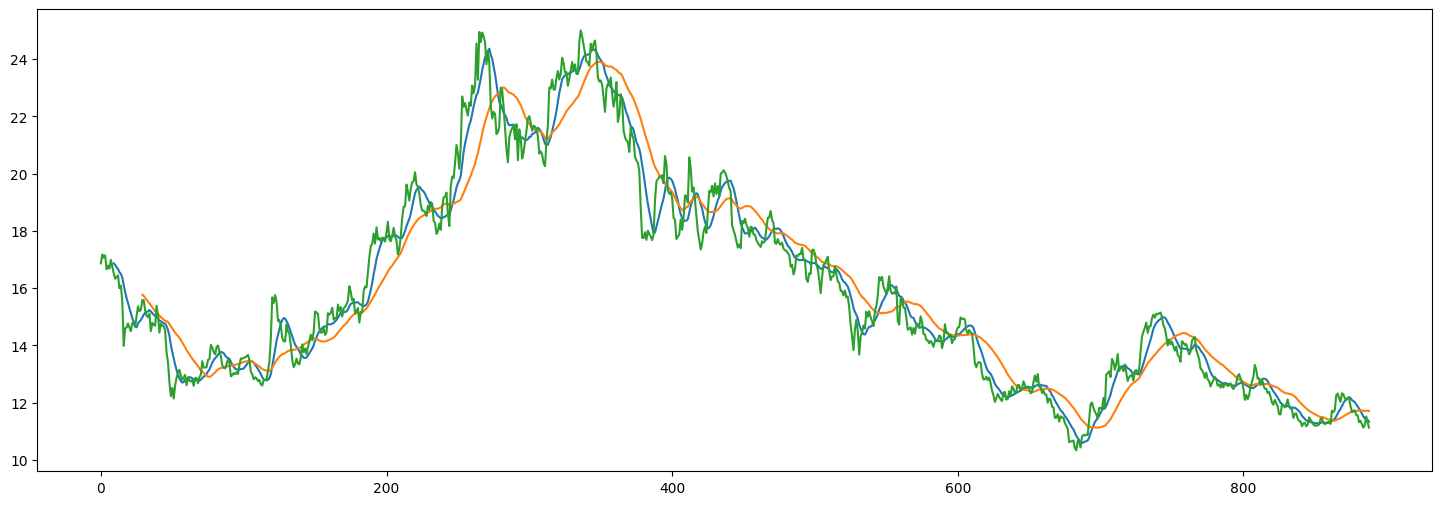

In [10]:
import talib

fig=plt.figure(figsize=(18,6))
talib.SMA(df.close, timeperiod=10).plot()
talib.SMA(df.close, timeperiod=30).plot()
df.close.plot()

### pybrokder中的交叉函数cross

cross(a: ndarray[Any, dtype[float64]], b: ndarray[Any, dtype[float64]]) → ndarray[Any, dtype[bool_]]

详细的指标意义：检查数组 a 是否上穿数组 b。当 a 上穿 b 时，返回的数组对应位置的值为 1（True），否则为 0（False）。

参数：
● a – 数据的 NumPy 数组。
● b – 数据的 NumPy 数组。

In [11]:
import talib
from pybroker.vect import cross

cross(talib.SMA(df.close, timeperiod=10).values, talib.SMA(df.close, timeperiod=30).values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
if 0:
    print(2)
else:
    print(3)

3


### talib指标在pybroker策略的使用

In [12]:
# 定义短期均线指标
sma_10 = pybroker.indicator('sma_10', lambda data: talib.SMA(data.close, timeperiod=10))
# 定义长期均线指标
sma_30 = pybroker.indicator('sma_30', lambda data: talib.SMA(data.close, timeperiod=30))

def double_ma_strategy(ctx: ExecContext):
    # 获取短期均线数据
    sma_10_values = ctx.indicator('sma_10')
    # 获取长期均线数据
    sma_30_values = ctx.indicator('sma_30')

    # 检查短期均线是否上穿长期均线（产生买入信号）
    buy_signal = cross(sma_10_values, sma_30_values)[-1]
    # 检查短期均线是否下穿长期均线（产生卖出信号）
    sell_signal = cross(sma_30_values, sma_10_values)[-1]

    if buy_signal and not ctx.long_pos():
        # 计算购买的股票数量，这里使用全部资金购买
        target_size = 1
        shares = ctx.calc_target_shares(target_size)
        ctx.buy_shares = shares
        print('买入信号',ctx.dt,buy_signal)

    if sell_signal and ctx.long_pos():
        ctx.sell_all_shares()
        print('卖出信号',ctx.dt,sell_signal)

strategy = Strategy(data_source=akshare, start_date='2022-01-01', end_date='2023-01-01')
strategy.add_execution(double_ma_strategy, ['000001.SZ','002594.SZ'],indicators=[sma_10, sma_30])
result = strategy.backtest(warmup=30)

Backtesting: 2022-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:02 ETA:   0:00:06
100% (4 of 4) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test split: 2022-01-04 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 242) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (131 of 242) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (242 of 242) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


买入信号 2022-03-02 00:00:00 1
卖出信号 2022-03-08 00:00:00 1
买入信号 2022-03-29 00:00:00 1
买入信号 2022-04-06 00:00:00 1
卖出信号 2022-04-28 00:00:00 1
卖出信号 2022-05-05 00:00:00 1
买入信号 2022-05-11 00:00:00 1
买入信号 2022-06-27 00:00:00 1
卖出信号 2022-07-12 00:00:00 1
卖出信号 2022-07-15 00:00:00 1
买入信号 2022-08-31 00:00:00 1
卖出信号 2022-09-27 00:00:00 1
买入信号 2022-11-09 00:00:00 1
买入信号 2022-11-16 00:00:00 1
卖出信号 2022-11-22 00:00:00 1
买入信号 2022-12-09 00:00:00 1
卖出信号 2022-12-29 00:00:00 1

Finished backtest: 0:00:05


In [13]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,002594.SZ,2022-03-03,402,NaN,247.43,0.0
2,sell,002594.SZ,2022-03-09,402,NaN,216.80,0.0
3,buy,002594.SZ,2022-03-30,379,NaN,229.62,0.0
4,buy,000001.SZ,2022-04-07,40,NaN,16.43,0.0
5,sell,002594.SZ,2022-04-29,379,NaN,237.29,0.0
6,sell,000001.SZ,2022-05-06,40,NaN,15.06,0.0
7,buy,002594.SZ,2022-05-12,357,NaN,253.20,0.0
8,buy,000001.SZ,2022-06-28,10,NaN,14.54,0.0
9,sell,002594.SZ,2022-07-13,357,NaN,305.30,0.0


## MACD

https://zhuanlan.zhihu.com/p/348987788

* 指数移动平均

EMA(t)=平滑常数\*当前价格+(1-平滑常数)*EMA(t-1)

* 指数平滑异同移动平均线（moving average convergence-divergence, MACD）。MACD是以三个指数移动平均为基础，以两条曲线的形式出现在图表中，其两条线的交叉点，是一种交易信号。

最初的MACD指标由两条线组成：一条实线（叫作MACD线）和一条虚线（叫作信号线）。MACD线由两个指数移动平均（EMA）计算而来，其对价格的反应相对较快。信号线是以MACD线为基础，通过对MACD线以EMA的方式进行运算，实现对MACD线的平滑，其对价格变动的反应相对较慢。在阿佩尔最初的体系中，较快的MACD线穿过较慢的信号线上升或者下降，为买入或者卖出的信号。大多数技术分析软件都提供MACD指标。

手工做出MACD指标的步骤如下：

（1）计算12日收盘价的EMA；

（2）计算26日收盘价的EMA；

（3）用12日收盘价的EMA减去26日收盘价的EMA，将其差值画成一条实线，这就是较快的MACD线；也叫离差值（DIF）

（4）计算这条实线的9日EMA，将其结果画成一条虚线，这就是较慢的信号线。也叫离差平均值（DEA）。

（5）（DIF-DEA）×2即为MACD值。

每一个价格都反映了所有的市场参与者那一刻对股票价值的共识。移动平均值反映了一段时间内的市场价值共识的平均水平——它像是所有的市场参与者共识的连环照。较长的移动平均反映的是较长时间周期内市场价值共识的平均水平，而较短的移动平均则反映了较短时间周期内市场价值共识的平均水平。

MACD线和信号线的交点表明了市场中空方和多方实力变换的平衡点。较快的MACD线反映的是短期内大众的心理变化，而较慢的信号线则反映了大众心理在较长期的变化。当较快的MACD线上升超过信号线时，表示多方主导了市场，这时候最好做多方；当较快的线落到较慢的信号线下面时，表示空方主导了市场，做空方比较有利。

* MACD柱状线

相比原始的MACD线，MACD柱状线能够提供更深刻的关于多空力量均衡的信息。它不仅能分辨出哪种力量处于主导地位，而且能够分辨其力量是在逐渐增强还是在减弱。MACD柱状线是技术分析师最好用的工具之一。

MACD柱状线=MACD线-信号线

MACD柱状线测量的是MACD线和信号线之间的差值。它将差值画为一根根柱状线——为一系列垂直的线条。

MACD柱状线的斜率方向揭示了市场中的主导力量。向上倾斜的MACD柱状线表示多方的力量在增强，而向下倾斜的MACD柱状线则意味着空方的力量在增强。


* MACD简单策略：

快线DIF与慢线DEA都大于零，快线向上突破慢线，则买入

快线DIF与慢线DEA都小于零，快线向下突破慢线，则卖出

In [17]:
df

,date,symbol,open,high,low,close,volume
0,2020-01-02,000001,16.65,16.95,16.55,16.87,1530232
1,2020-01-03,000001,16.94,17.31,16.92,17.18,1116195
2,2020-01-06,000001,17.01,17.34,16.91,17.07,862084
3,2020-01-07,000001,17.13,17.28,16.95,17.15,728608
4,2020-01-08,000001,17.00,17.05,16.63,16.66,847824
...,...,...,...,...,...,...,...
884,2023-08-24,000001,11.29,11.32,11.05,11.13,1291271
885,2023-08-25,000001,11.10,11.33,11.08,11.23,845350
886,2023-08-28,000001,11.84,11.93,11.49,11.52,1997610
887,2023-08-29,000001,11.47,11.49,11.13,11.31,1964961


In [29]:
import riskfolio as rp

In [19]:
x,y,z=talib.MACD(df.close,fastperiod=12, slowperiod=26, signalperiod=9)

In [22]:
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from pyecharts.charts import Kline, Line, Bar, Grid

In [27]:
x

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
884   -0.115714
885   -0.131597
886   -0.119406
887   -0.125247
888   -0.142755
Length: 889, dtype: float64

In [23]:
L_macd=Line()
L_macd.add_xaxis(x.index.tolist())
L_macd.add_yaxis("DIF",x.tolist(),label_opts=opts.LabelOpts(is_show=False))
L_macd.render_notebook()

In [18]:
from pybroker import IndicatorSet
from pybroker.indicator import macd

indicator_set = IndicatorSet()
indicator_set.add(macd(name='my_macd', short_length=12, long_length=26, smoothing=9))
indicator_set(df)

Computing indicators...


  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


,symbol,date,my_macd
0,000001,2020-01-02,0.000000
1,000001,2020-01-03,0.677923
2,000001,2020-01-06,0.836162
3,000001,2020-01-07,1.177791
4,000001,2020-01-08,0.036306
...,...,...,...
884,000001,2023-08-24,-7.327557
885,000001,2023-08-25,-6.566715
886,000001,2023-08-28,-4.182659
887,000001,2023-08-29,-3.409413
